# 

In [129]:
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
import numpy as np
import time
from pathlib import Path
import json
import logging

from daq_data.daq_data_resources import unpack_pano_image, format_stream_images_response
from daq_data.daq_data_client import DaqDataClient

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [130]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import MaxNLocator
from mpl_toolkits.axes_grid1 import make_axes_locatable
from collections import deque
import textwrap

class PanoImagePreviewer:
    def __init__(
            self,
            stream_movie_data: bool,
            stream_pulse_height_data: bool,
            module_id_whitelist: list[int],
            logger: logging.Logger,
            text_width=25,
            font_size=7,
            row_height=2.8,
            window_size=100,
    ) -> None:
        self.stream_movie_data = stream_movie_data
        self.stream_pulse_height_data = stream_pulse_height_data
        self.module_id_whitelist = module_id_whitelist
        self.logger = logger

        self.seen_modules = set()
        self.axes_map = {}
        self.cbar_map = {}
        self.im_map = {}
        self.window_size = window_size
        self.max_pix_map = {'PULSE_HEIGHT': deque(maxlen=self.window_size), 'MOVIE': deque(maxlen=self.window_size)}
        self.min_pix_map = {'PULSE_HEIGHT': deque(maxlen=self.window_size), 'MOVIE': deque(maxlen=self.window_size)}

        self.fig = None
        self.text_width = text_width
        self.font_size = font_size
        self.cmap = 'plasma'
        self.row_height = row_height
        self.num_rescale = 0

    def setup_layout(self, modules):
        if self.fig is not None:
            plt.close(self.fig)
        modules = sorted(modules)
        n_modules = len(modules)
        self.fig, axs = plt.subplots(n_modules, 2, figsize=(self.row_height * 2.2, self.row_height * n_modules))
        if n_modules == 1:
            axs = np.array([axs])

        self.num_rescale = 0
        self.axes_map.clear()
        self.cbar_map.clear()
        self.im_map.clear()
        for row, module_id in enumerate(modules):
            self.axes_map[(module_id, 'PULSE_HEIGHT')] = axs[row, 0]
            self.axes_map[(module_id, 'MOVIE')] = axs[row, 1]

            im_ph = axs[row, 0].imshow(np.zeros((32, 32)), cmap=self.cmap)
            self.im_map[(module_id, 'PULSE_HEIGHT')] = im_ph
            im_mov = axs[row, 1].imshow(np.zeros((32, 32)), cmap=self.cmap)
            self.im_map[(module_id, 'MOVIE')] = im_mov

            divider_ph = make_axes_locatable(axs[row, 0])
            cax_ph = divider_ph.append_axes('right', size='5%', pad=0.05)
            cbar_ph = self.fig.colorbar(im_ph, cax=cax_ph)
            self.cbar_map[(module_id, 'PULSE_HEIGHT')] = cbar_ph

            divider_mov = make_axes_locatable(axs[row, 1])
            cax_mov = divider_mov.append_axes('right', size='5%', pad=0.05)
            cbar_mov = self.fig.colorbar(im_mov, cax=cax_mov)
            self.cbar_map[(module_id, 'MOVIE')] = cbar_mov
        self.fig.tight_layout()

    def update(self, stream_images_response):
        module_id, pano_type, header, img = unpack_pano_image(stream_images_response.pano_image)
        pano_image = stream_images_response.pano_image
        frame_number = pano_image.frame_number
        file = pano_image.file

        # If this module is new, update layout and clear output before redrawing
        if module_id not in self.seen_modules:
            self.seen_modules.add(module_id)
            self.setup_layout(self.seen_modules)

        self.max_pix_map[pano_type].append(np.max(img))
        self.min_pix_map[pano_type].append(np.min(img))
        vmax = np.quantile(self.max_pix_map[pano_type], 0.95)
        vmin = np.quantile(self.min_pix_map[pano_type], 0.05)
        im = self.im_map[(module_id, pano_type)]
        im.set_data(img)
        im.set_clim(vmin, vmax)

        cbar = self.cbar_map.get((module_id, pano_type))
        cbar.ax.tick_params(labelsize=8)
        cbar.locator = MaxNLocator(nbins=6)
        cbar.update_ticks()
        ax = self.axes_map.get((module_id, pano_type))
        if ax is None:
            return

        ax_title = (f"{pano_type}"
                    + ("\n" if 'quabo_num' not in header else f": Q{int(header['quabo_num'])}\n")
                    + f"unix_t = {header['pandas_unix_timestamp'].time()}\n"
                    + f"frame_no = {frame_number}\n")
        ax_title += textwrap.fill(f"file = {file}", width=self.text_width)

        ax.set_title(ax_title, fontsize=self.font_size)
        ax.tick_params(axis='both', which='major', labelsize=8, length=4, width=1)

        start = pff.parse_name(file)['start'] if 'pff' in globals() else ''
        if len(self.module_id_whitelist) > 0:
            plt_title = f"Obs data from {start}, module_ids={set(self.module_id_whitelist)} [filtered]"
        else:
            plt_title = f"Obs data from {start}, module_ids={self.seen_modules} [all]"
        if self.num_rescale < len(self.seen_modules) * 3:
            self.fig.tight_layout()
            self.num_rescale += 1
        self.fig.suptitle(plt_title)

        clear_output(wait=True)
        display(self.fig)


In [131]:
# load config and paths
cfg_dir = Path('daq_data/config')
daq_config_file = 'daq_config_grpc_simulate.json'
hp_io_config_simulate_file = 'hp_io_config_simulate.json'
with open(cfg_dir / hp_io_config_simulate_file, 'r') as f:
    hp_io_cfg = json.load(f)

In [160]:
# initialize the server
with DaqDataClient(cfg_dir / daq_config_file) as ddc:
    valid_daq_hosts = ddc.get_valid_daq_hosts()
    for host in valid_daq_hosts:
        print(host)
        ddc.reflect_services(host)
        # initialize the server with simulation data
        init_hp_io_response = ddc.init_hp_io(host, hp_io_cfg)
        if not init_hp_io_response.success:
            print('failed to initialize')
            break
        print(init_hp_io_response)

localhost


found services: ['daqdata.DaqData', 'grpc.reflection.v1alpha.ServerReflection']

found DaqData service with name: daqdata.DaqData

found: rpc StreamImages(StreamImagesRequest) returns (stream StreamImagesResponse)

found: rpc InitHpIo(InitHpIoRequest) returns (InitHpIoResponse)

success: true



02:05:52 INFO     [tid=8757206784] [__exit__()] closed channel to localhost:50051             ]8;id=703634;file:///Users/nico/panoseti/panoseti_grpc/daq_data/daq_data_client.py\daq_data_client.py]8;;\:]8;id=291157;file:///Users/nico/panoseti/panoseti_grpc/daq_data/daq_data_client.py#84\84]8;;\

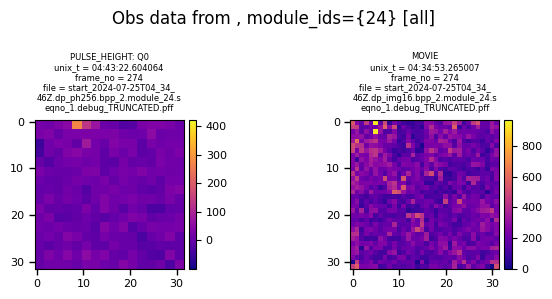

02:06:51 INFO     [tid=8757206784] [__exit__()] closed channel to localhost:50051             ]8;id=759149;file:///Users/nico/panoseti/panoseti_grpc/daq_data/daq_data_client.py\daq_data_client.py]8;;\:]8;id=912238;file:///Users/nico/panoseti/panoseti_grpc/daq_data/daq_data_client.py#84\84]8;;\

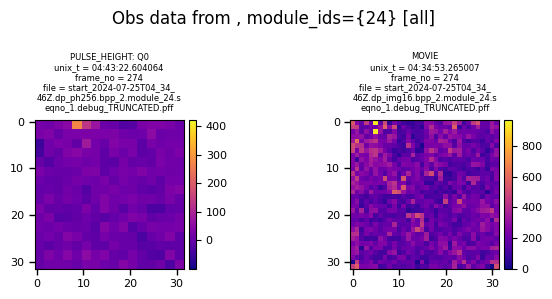

In [161]:
# stream images: config 
stream_movie_data = True
stream_pulse_height_data = True
update_interval_seconds=0.5

# stream images: calls
with DaqDataClient(cfg_dir / daq_config_file) as ddc:
    valid_daq_hosts = ddc.get_valid_daq_hosts()
    # create visualizer
    previewer = PanoImagePreviewer(
        stream_movie_data, stream_pulse_height_data, [], ddc.logger, row_height=3, font_size=6, text_width=30, window_size=1000
    )
    # Make StreamImages RPCs to all active DAQ nodes
    daq_image_streams = []
    for host in valid_daq_hosts:
        daq_image_stream = ddc.stream_images(
            host,
            stream_movie_data,
            stream_pulse_height_data,
            update_interval_seconds,
            wait_for_ready=True
        )
        daq_image_streams.append(daq_image_stream)

    # Update plots with data from StreamImagesResponses 
    while True:
        for daq_image_stream in daq_image_streams:
            resp = next(daq_image_stream)
            previewer.update(resp)